![Customer Satisfaction Analysis](/kaggle/input/photo-of-cs)


# **Introduction**
##### This Jupyter Notebook delves into the Olist dataset, encompassing a diverse range of information from Brazil's largest department store marketplace. Our aim is to uncover insights into customer satisfaction, delivery efficiency, and purchasing patterns through statistical analysis, machine learning, and data visualization.

### **Analyzed Questions**
1. Sales Trends Over Time: Identifying periods of high demand to inform inventory and marketing strategies.
2. Popular Product Categories: Highlighting top-selling categories to prioritize stock and marketing efforts.
3. Geographic Distribution of Sales: Tailoring logistics strategies to improve delivery times in key markets.
4. Influence of Payment Types on Purchases: Enhancing the checkout process to increase conversion rates.
5. Customer Satisfaction Distribution: Identifying improvement areas in product quality, service, and delivery.
6. Factors Affecting Delivery Times: Analyzing and optimizing delivery performance to reduce late deliveries.
7. Time to Delivery vs. Customer Satisfaction: Examining the impact of delivery times on satisfaction levels.
8. Key Predictors of Customer Satisfaction: Using machine learning to focus efforts on aspects crucial to customers.
9. Actual vs. Estimated Delivery Times: Assessing delivery estimate accuracy and its satisfaction impact.
10. Strategies for Business Improvement: Formulating recommendations based on data insights to enhance customer experience and business performance.
#### Through this exploration, we aim to provide actionable insights for data-driven decision-making to enhance customer satisfaction and overall business performance

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os


In [20]:
def merge_datasets(datasets):
    # Start by merging orders with customers
    merged = pd.merge(datasets['olist_orders_dataset'], datasets['olist_customers_dataset'], on='customer_id', how='left')

    # Add other datasets with the correct merge keys
    merge_keys = {
        'order_items': 'order_id',
        'order_payments': 'order_id',
        'order_reviews': 'order_id',
        'sellers': 'seller_id',
        'products': 'product_id',
        'product_category_name_translation': 'product_category_name'  # Make sure this dataset is loaded correctly
    }

    for name, key in merge_keys.items():
        if name in datasets:
            merged = pd.merge(merged, datasets[name], on=key, how='left')

    return merged

In [21]:
# Load individual datasets
olist_customers_df = pd.read_csv('olist_customers_dataset.csv')
order_items_df = pd.read_csv('olist_order_items_dataset.csv')
order_payments_df = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews_df = pd.read_csv('olist_order_reviews_dataset.csv')
olist_orders_df = pd.read_csv('olist_orders_dataset.csv')
sellers_df = pd.read_csv('olist_sellers_dataset.csv')
products_df = pd.read_csv('olist_products_dataset.csv')
product_category_name_translation_df = pd.read_csv('product_category_name_translation.csv')

# Define the datasets dictionary
datasets = {
    'olist_customers_dataset': olist_customers_df,
    'order_items': order_items_df,
    'order_payments': order_payments_df,
    'order_reviews': order_reviews_df,
    'olist_orders_dataset': olist_orders_df,
    'sellers': sellers_df,
    'products': products_df,
    'product_category_name_translation': product_category_name_translation_df
}

# Now, you can call the merge_datasets function with the loaded datasets
merged_df = merge_datasets(datasets)

In [22]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       119143 non-null  object 
 1   customer_id                    119143 non-null  object 
 2   order_status                   119143 non-null  object 
 3   order_purchase_timestamp       119143 non-null  object 
 4   order_approved_at              118966 non-null  object 
 5   order_delivered_carrier_date   117057 non-null  object 
 6   order_delivered_customer_date  115722 non-null  object 
 7   order_estimated_delivery_date  119143 non-null  object 
 8   customer_unique_id             119143 non-null  object 
 9   customer_zip_code_prefix       119143 non-null  int64  
 10  customer_city                  119143 non-null  object 
 11  customer_state                 119143 non-null  object 
 12  order_item_id                 

In [23]:
# check for duplicates
merged_df.duplicated().sum()

np.int64(0)

In [24]:
# check for missing values by percentage in each column
merged_df.isnull().sum() / len(merged_df) * 100

order_id                          0.000000
customer_id                       0.000000
order_status                      0.000000
order_purchase_timestamp          0.000000
order_approved_at                 0.148561
order_delivered_carrier_date      1.750837
order_delivered_customer_date     2.871339
order_estimated_delivery_date     0.000000
customer_unique_id                0.000000
customer_zip_code_prefix          0.000000
customer_city                     0.000000
customer_state                    0.000000
order_item_id                     0.699160
product_id                        0.699160
seller_id                         0.699160
shipping_limit_date               0.699160
price                             0.699160
freight_value                     0.699160
payment_sequential                0.002518
payment_type                      0.002518
payment_installments              0.002518
payment_value                     0.002518
review_id                         0.836810
review_scor

In [25]:
# drop missing values column with more than 50% missing values
merged_df = merged_df.dropna(thresh=len(merged_df) * 0.5, axis=1)

# drop rows with missing values
merged_df = merged_df.dropna()

In [26]:
# check for missing values by percentage in each column
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113193 entries, 0 to 119142
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113193 non-null  object 
 1   customer_id                    113193 non-null  object 
 2   order_status                   113193 non-null  object 
 3   order_purchase_timestamp       113193 non-null  object 
 4   order_approved_at              113193 non-null  object 
 5   order_delivered_carrier_date   113193 non-null  object 
 6   order_delivered_customer_date  113193 non-null  object 
 7   order_estimated_delivery_date  113193 non-null  object 
 8   customer_unique_id             113193 non-null  object 
 9   customer_zip_code_prefix       113193 non-null  int64  
 10  customer_city                  113193 non-null  object 
 11  customer_state                 113193 non-null  object 
 12  order_item_id                  1131

In [27]:
# Clean and preprocess data
def preprocess_data(df):
    # Drop columns with more than 50% missing values
    df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)
    
    # Convert datetime columns
    datetime_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                    'order_delivered_customer_date', 'order_estimated_delivery_date', 
                    'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp']
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Calculate new features
    df['time_to_delivery'] = (df['order_delivered_customer_date'] - df['order_approved_at']).dt.days
    df['order_processing_time'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.days
    df['estimated_vs_actual_shipping'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
    df['product_volume_m3'] = (df['product_length_cm'] * df['product_width_cm'] * df['product_height_cm']) / 1000000
    df['satisfaction'] = (df['review_score'] >= 4).astype(int)
    df['order_value'] = df['price'] + df['freight_value']

    # create late delivery flag
    df['late_delivery'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype(int)


    # Drop rows with missing values
    df.dropna(inplace=True)

    # create seasonal features from order_purchase_timestamp
    df['order_month'] = df['order_purchase_timestamp'].dt.month
    df['order_day'] = df['order_purchase_timestamp'].dt.dayofweek
    df['order_hour'] = df['order_purchase_timestamp'].dt.hour

    return df

merged_df = preprocess_data(merged_df)

In [28]:
# drop unnecessary columns
merged_df.drop(['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'review_score', 'seller_zip_code_prefix']
               , axis=1, inplace=True) 
# save the cleaned dataset
merged_df.to_csv('olist_merged_data_clean.csv', index=False)

In [29]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113193 entries, 0 to 119142
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113193 non-null  object        
 1   customer_id                    113193 non-null  object        
 2   order_status                   113193 non-null  object        
 3   order_purchase_timestamp       113193 non-null  datetime64[ns]
 4   order_approved_at              113193 non-null  datetime64[ns]
 5   order_delivered_carrier_date   113193 non-null  datetime64[ns]
 6   order_delivered_customer_date  113193 non-null  datetime64[ns]
 7   order_estimated_delivery_date  113193 non-null  datetime64[ns]
 8   customer_unique_id             113193 non-null  object        
 9   customer_zip_code_prefix       113193 non-null  int64         
 10  customer_city                  113193 non-null  object        
 11  custo

In [30]:
# check summary statistics
merged_df.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,order_item_id,shipping_limit_date,price,freight_value,...,time_to_delivery,order_processing_time,estimated_vs_actual_shipping,product_volume_m3,satisfaction,order_value,late_delivery,order_month,order_day,order_hour
count,113193,113193,113193,113193,113193,113193.000000,113193.000000,113193,113193.000000,113193.000000,...,113193.00000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000,113193.000000
mean,2018-01-01 07:46:22.707817472,2018-01-01 18:12:25.359050496,2018-01-04 14:19:54.360985088,2018-01-13 18:22:26.739418624,2018-01-25 03:50:01.955951616,35085.687437,1.195065,2018-01-07 22:21:08.998047488,119.846650,20.002595,...,11.51899,0.269142,11.091092,0.015306,0.768210,139.849246,0.076984,6.037432,2.746928,14.764614
min,2016-10-03 09:44:50,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-27 00:00:00,1003.000000,1.000000,2016-10-08 10:34:01,0.850000,0.000000,...,-7.00000,0.000000,-189.000000,0.000168,0.000000,6.080000,0.000000,1.000000,0.000000,0.000000
25%,2017-09-13 14:12:25,2017-09-13 22:05:44,2017-09-15 20:07:55,2017-09-25 18:34:40,2017-10-04 00:00:00,11310.000000,1.000000,2017-09-20 13:24:55,39.900000,13.080000,...,6.00000,0.000000,6.000000,0.002856,1.000000,55.260000,0.000000,3.000000,1.000000,11.000000
50%,2018-01-20 09:22:45,2018-01-20 16:00:33,2018-01-24 00:23:35,2018-02-02 02:15:19,2018-02-16 00:00:00,24315.000000,1.000000,2018-01-26 14:14:20,74.900000,16.320000,...,9.00000,0.000000,12.000000,0.006612,1.000000,91.780000,0.000000,6.000000,3.000000,15.000000
75%,2018-05-05 13:57:15,2018-05-05 19:50:47,2018-05-08 14:07:00,2018-05-15 20:02:55,2018-05-28 00:00:00,58865.000000,1.000000,2018-05-10 19:15:24,132.980000,21.190000,...,15.00000,0.000000,16.000000,0.018468,1.000000,157.300000,0.000000,8.000000,4.000000,19.000000
max,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,99980.000000,21.000000,2020-04-09 22:35:08,6735.000000,409.680000,...,208.00000,30.000000,146.000000,0.296208,1.000000,6929.310000,1.000000,12.000000,6.000000,23.000000
std,NaN,NaN,NaN,NaN,NaN,29867.822574,0.687526,NaN,181.079901,15.711728,...,9.32641,0.747635,10.090406,0.023409,0.421977,188.111745,0.266567,3.221918,1.961298,5.324879


In [31]:
# Check the distribution of the CSAT percentage
merged_df['satisfaction'].value_counts() / len(merged_df) * 100

satisfaction
1    76.821005
0    23.178995
Name: count, dtype: float64

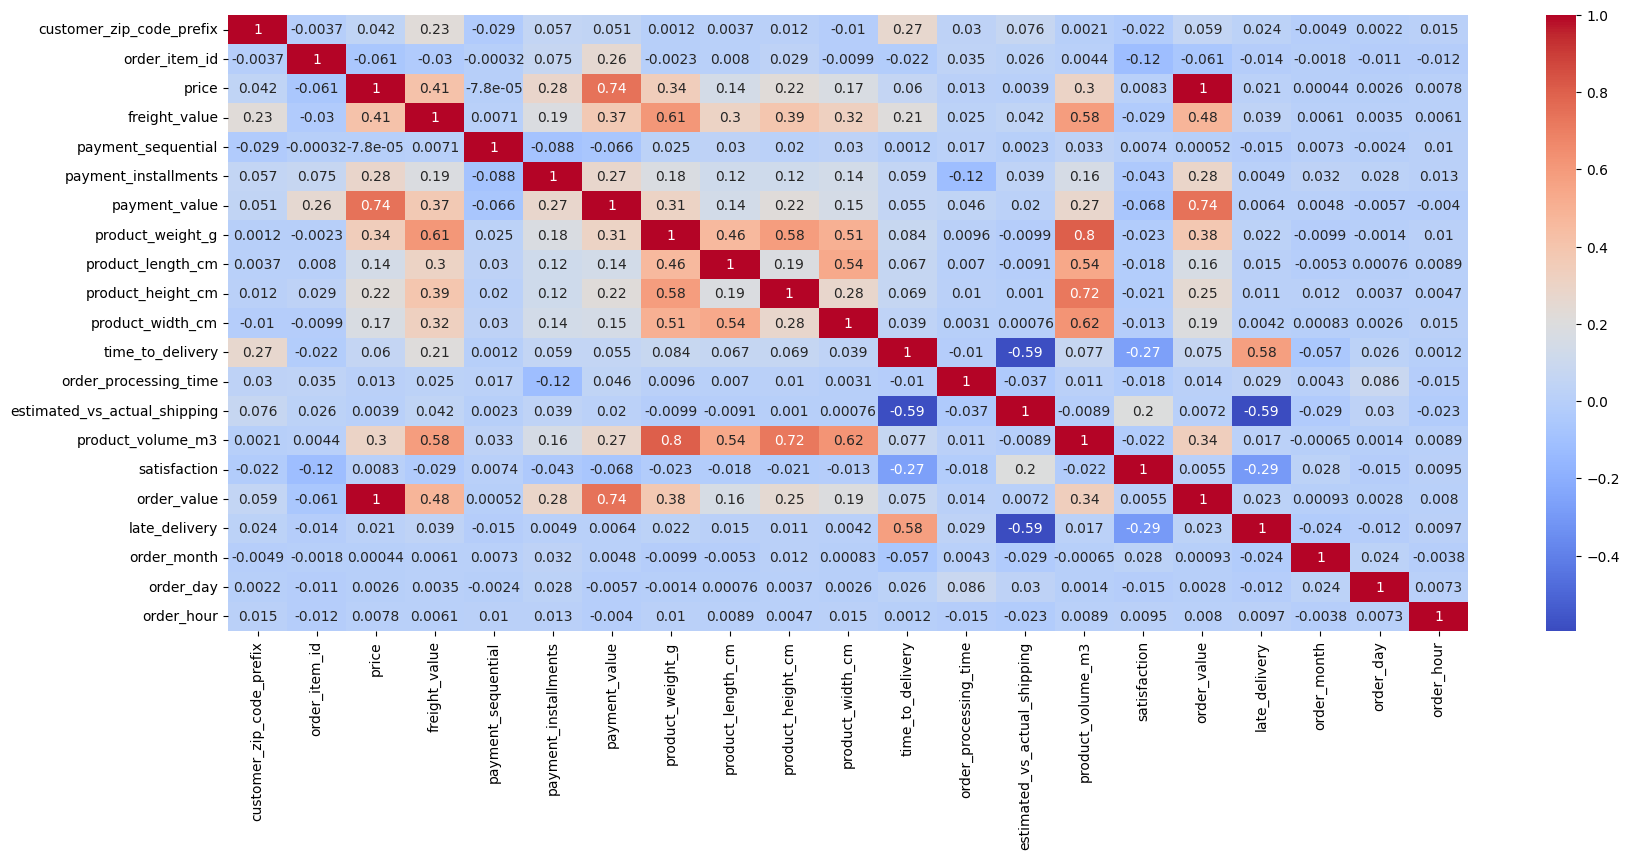

In [32]:
# Select only numeric columns from the DataFrame
numeric_columns = merged_df.select_dtypes(include=[np.number])

# Plot the correlation matrix heatmap with numeric columns
plt.figure(figsize=(20, 8))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm')
plt.show()


# Univariate Analysis
1. Sales Trends Over Time

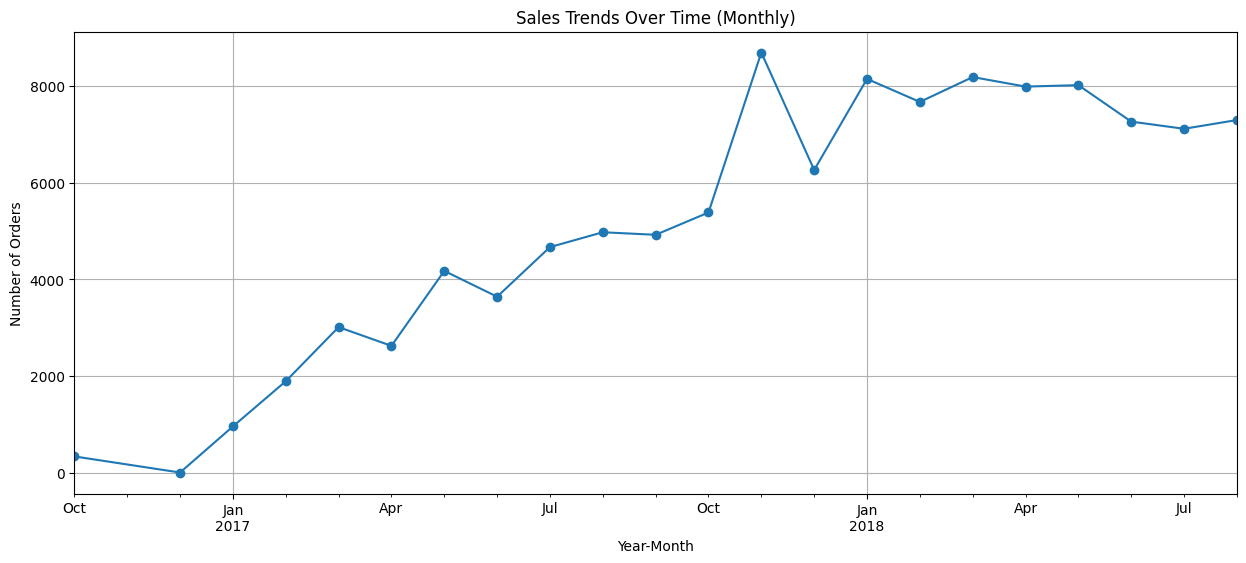

In [33]:
# Ensure that the order_purchase_timestamp is in datetime format
merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])

# Extract year and month for aggregation
merged_df['year_month'] = merged_df['order_purchase_timestamp'].dt.to_period('M')

# Aggregate data by year and month
sales_trends = merged_df.groupby('year_month').size()

# Plotting
plt.figure(figsize=(15, 6))
sales_trends.plot(kind='line', marker='o')
plt.title('Sales Trends Over Time (Monthly)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()


### We can see an increase in the Sales trend over months, and its peaks at November 2017.

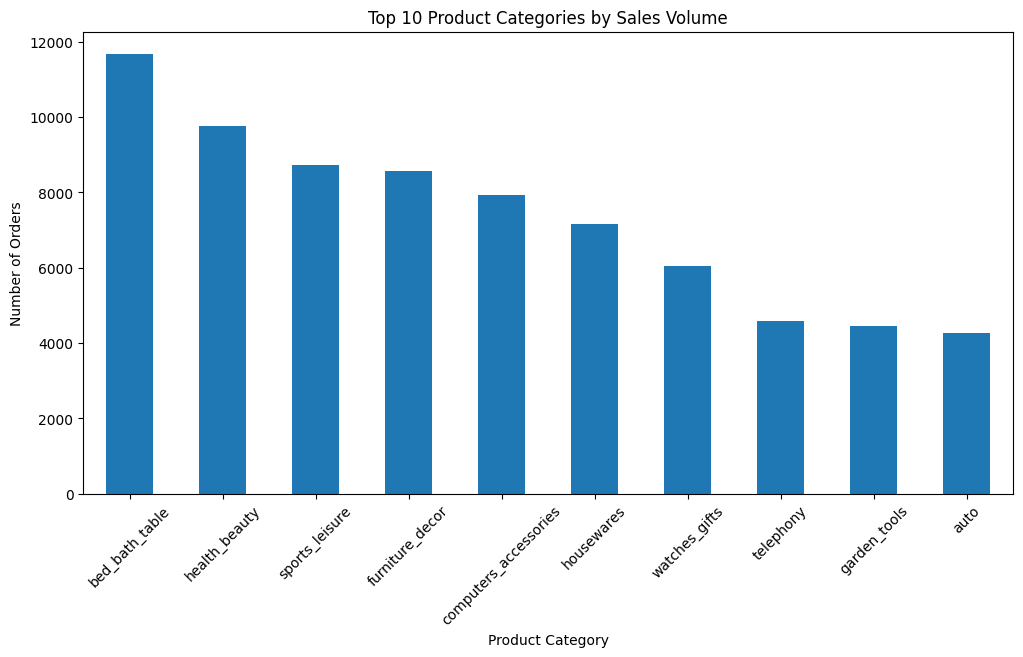

In [34]:
# Grouping data by product category
category_analysis = merged_df.groupby('product_category_name_english').size().sort_values(ascending=False)

# Plotting the top 10 product categories by sales volume
plt.figure(figsize=(12, 6))
category_analysis.head(10).plot(kind='bar')
plt.title('Top 10 Product Categories by Sales Volume')
plt.xlabel('Product Category')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

##### ***Top 10 Product Categories by Sales Volume:*** Bed Bath & Table, Health & Beauty, and Sports & Leisure are the top categories, indicating consumer priorities in home living, personal care, and active lifestyle.

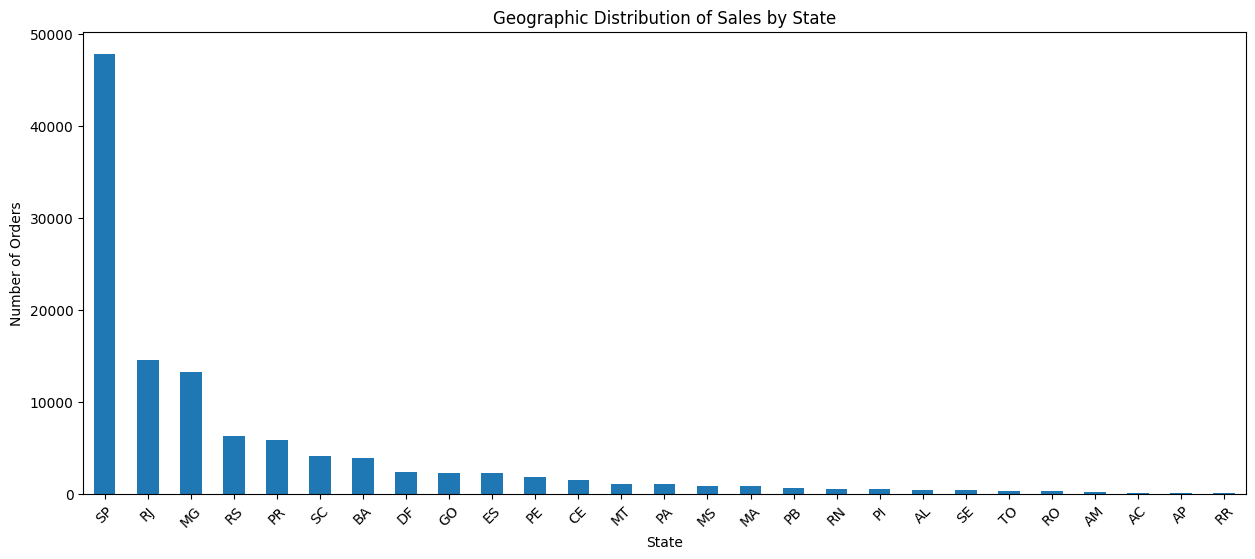

In [35]:
# Grouping data by customer state
state_sales = merged_df.groupby('customer_state').size().sort_values(ascending=False)

# Plotting sales distribution by state
plt.figure(figsize=(15, 6))
state_sales.plot(kind='bar')
plt.title('Geographic Distribution of Sales by State')
plt.xlabel('State')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()


##### ***Geographic Distribution of Sales by State:*** Sales are heavily concentrated in São Paulo, indicating a central hub of economic activity or consumer concentration

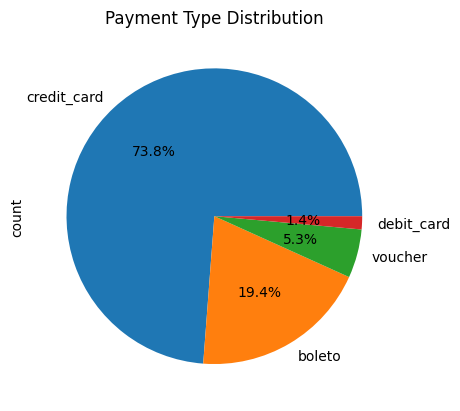

In [36]:
# payment type
merged_df['payment_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Payment Type Distribution')
plt.show()

##### ***Payment Type Distribution:*** Credit cards are the overwhelmingly preferred payment method, suggesting trust in and availability of credit payment facilities.

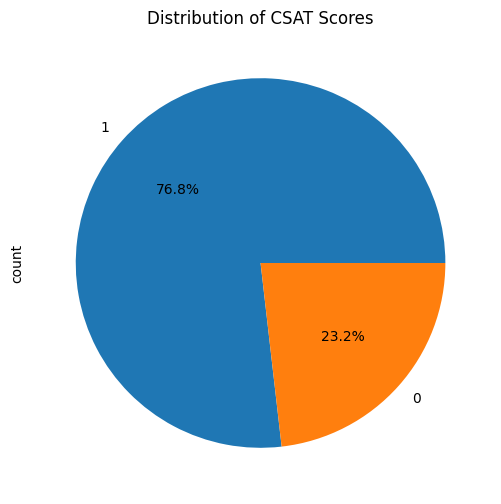

In [37]:
# Distribution of CSAT percentages on pie chart
plt.figure(figsize=(12, 6))
merged_df['satisfaction'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of CSAT Scores')
plt.show()

##### ***Distribution of CSAT Scores:*** A significant majority of customers report satisfaction, highlighting effective service or product quality but still there is room for improvement.

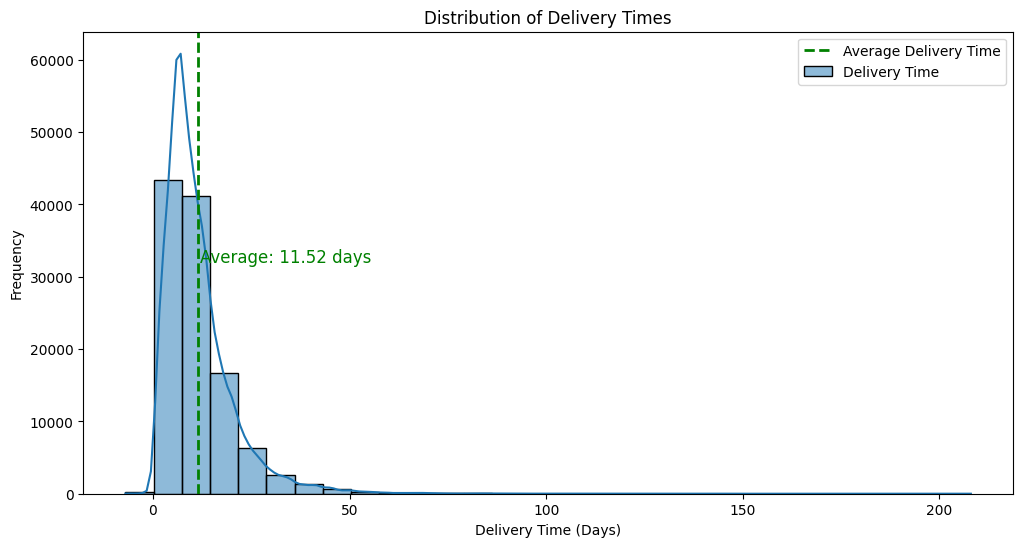

In [38]:
#Calculate the average delivery time
average_delivery_time = merged_df['time_to_delivery'].mean()

# Plot the distribution of delivery times
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['time_to_delivery'].dropna(), bins=30, kde=True, label='Delivery Time')
plt.axvline(average_delivery_time, color='green', linestyle='dashed', linewidth=2, label='Average Delivery Time')
plt.text(average_delivery_time + 0.5, plt.ylim()[1] / 2, f'Average: {average_delivery_time:.2f} days', color='green', fontsize=12, ha='left')
plt.title('Distribution of Delivery Times')
plt.xlabel('Delivery Time (Days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### We found that the average delivery time is 11.52 days.

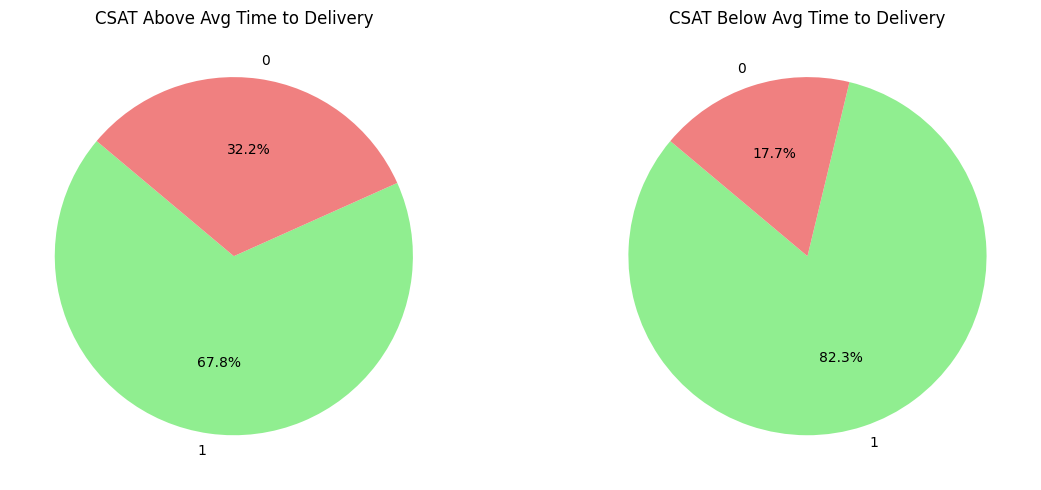

In [39]:
# Calculate the average delivery time
average_delivery_time = merged_df['time_to_delivery'].mean()

# Initialize counts and labels lists for CSAT categories
csat_labels_above, csat_labels_below = [], []
csat_counts_above, csat_counts_below = [], []

# Filter the DataFrame for CSAT values above and below average time_to_delivery
csat_above_avg = merged_df[merged_df['time_to_delivery'] >= average_delivery_time]
csat_below_avg = merged_df[merged_df['time_to_delivery'] < average_delivery_time]

# Calculate the counts for CSAT categories above average time_to_delivery
csat_counts_above = csat_above_avg['satisfaction'].value_counts().tolist()
csat_labels_above = csat_above_avg['satisfaction'].value_counts().index.tolist()

# Calculate the counts for CSAT categories below average time_to_delivery
csat_counts_below = csat_below_avg['satisfaction'].value_counts().tolist()
csat_labels_below = csat_below_avg['satisfaction'].value_counts().index.tolist()

# Create data for the pie charts
colors = ['lightgreen', 'lightcoral']

# Create the two pie charts
plt.figure(figsize=(12, 5))

# Pie chart for CSAT above average time_to_delivery
plt.subplot(1, 2, 1)
plt.pie(csat_counts_above, labels=csat_labels_above, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('CSAT Above Avg Time to Delivery')

# Pie chart for CSAT below average time_to_delivery
plt.subplot(1, 2, 2)
plt.pie(csat_counts_below, labels=csat_labels_below, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('CSAT Below Avg Time to Delivery')

plt.tight_layout()
plt.show()

### We can see that the higher CSAT scores are mostly above average.

# Bivariate Analysis

In [40]:

# Group by month to calculate average Time to Delivery and proportion of late deliveries
monthly_delivery_stats = merged_df.groupby('order_month').agg(
    avg_time_to_delivery=('time_to_delivery', 'mean'),
    proportion_late=('late_delivery', lambda x: (x > 0).mean())
).reset_index()

# Create a plot using Plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add a bar for average Time to Delivery
fig.add_trace(
    go.Bar(x=monthly_delivery_stats['order_month'], y=monthly_delivery_stats['avg_time_to_delivery'], 
           name='Avg. Time to Delivery (days)'),
    secondary_y=False,
)

# Add a line for the proportion of late deliveries
fig.add_trace(
    go.Scatter(x=monthly_delivery_stats['order_month'], y=monthly_delivery_stats['proportion_late'], 
               name='Proportion of Late Deliveries', mode='lines+markers', marker=dict(color='red')),
    secondary_y=True,
)

# Add titles and labels
fig.update_layout(
    title='Proportion of Late Delivery vs Average Time to Delivery in Monthly Trends',
    xaxis_title='Month',
    yaxis_title='Average Time to Delivery (days)',
    yaxis2_title='Proportion of Late Deliveries',
    legend=dict(y=0.5, traceorder='reversed', font_size=16)
)

# Show the plot
fig.show()

### Average Time to Delivery and Proportion of Late Deliveries are increasing in the months of Febrauary, March and November, December.

In [41]:
# Preparing the data
grouped_data = merged_df.groupby(['order_month', 'late_delivery'])['product_weight_g'].count().reset_index()
grouped_data = grouped_data.pivot(index='order_month', columns='late_delivery', values='product_weight_g').fillna(0)

# Creating the bar for each 'late_delivery' status
bars = []
for late_delivery_status in grouped_data.columns:
    bars.append(go.Bar(name=str(late_delivery_status),
                       x=grouped_data.index,
                       y=grouped_data[late_delivery_status]))

# Creating the figure and adding the bars
fig = go.Figure(data=bars)

# Change the bar mode to stacked
fig.update_layout(barmode='stack', 
                  title='Count of Product Weight by Month and Late Delivery Status',
                  xaxis_title='Order Month',
                  yaxis_title='Count of Product Weight')

# Show the plot
fig.show()

### Product weight late delivery is increasing in the months of Febrauary, March and November.

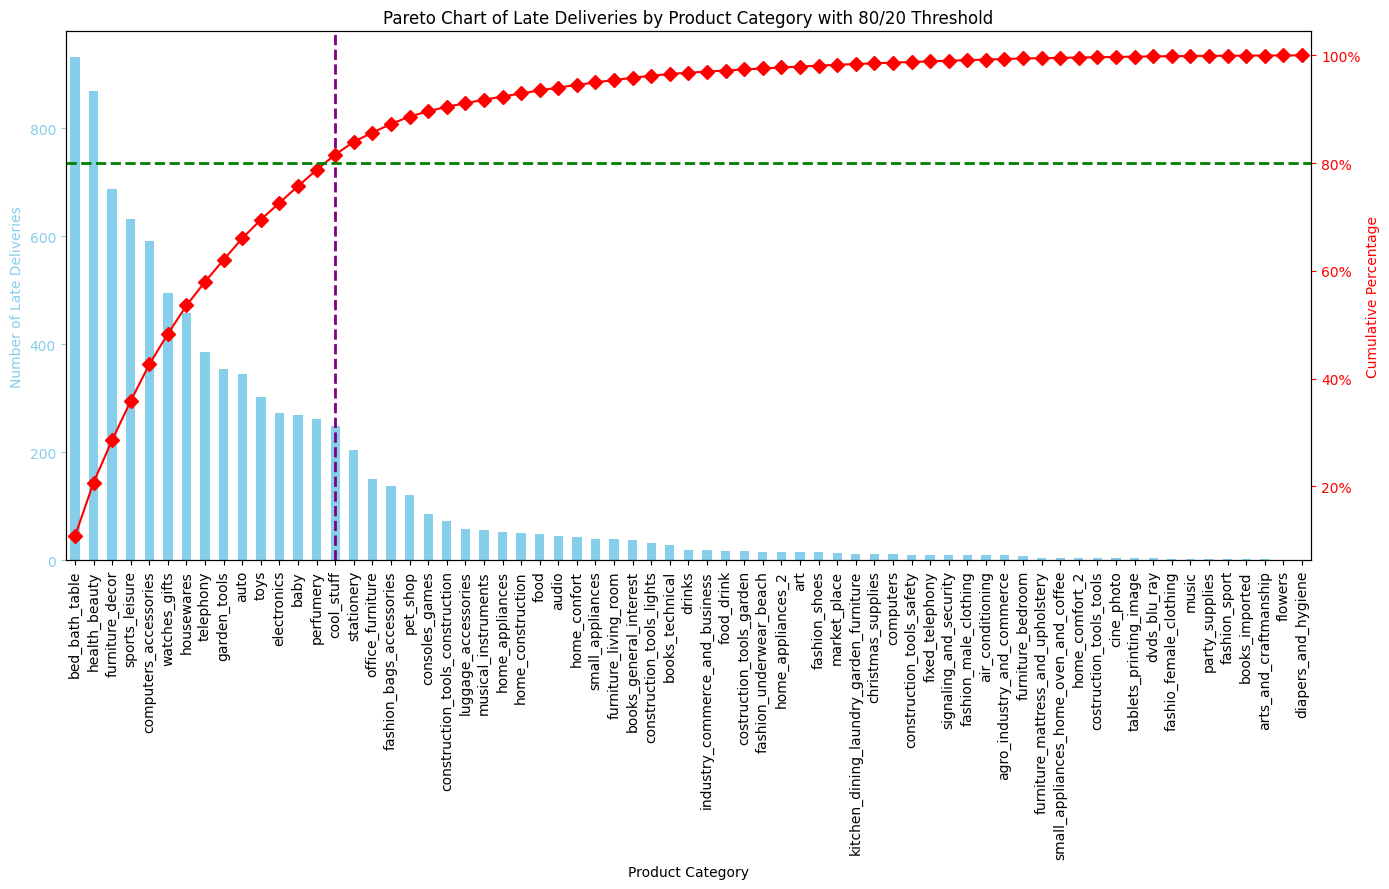

In [42]:
from matplotlib.ticker import PercentFormatter

# Calculate the percentage of late deliveries by category
late_deliveries_by_category = merged_df[merged_df['late_delivery'] == 1]['product_category_name_english'].value_counts()
total_late_deliveries = late_deliveries_by_category.sum()
late_deliveries_by_category_percent = (late_deliveries_by_category / total_late_deliveries).cumsum() * 100

# Modifying the Pareto Chart to include lines for 80% and 20% thresholds

# Recreating the Pareto Chart with modifications
fig, ax = plt.subplots(figsize=(14, 9))
late_deliveries_by_category.plot(kind='bar', ax=ax, color='skyblue')
ax2 = ax.twinx()
ax2.plot(late_deliveries_by_category_percent.index, late_deliveries_by_category_percent.values, color='red', marker='D', ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Adding lines for the 80% and 20% thresholds
ax2.axhline(80, color='green', linestyle='--', linewidth=2)
# Identifying the point where cumulative percentage surpasses 80%
category_80_idx = late_deliveries_by_category_percent[late_deliveries_by_category_percent >= 80].index[0]
category_80_position = late_deliveries_by_category.index.get_loc(category_80_idx)

ax.axvline(category_80_position, color='purple', linestyle='--', linewidth=2)

ax.tick_params(axis='y', colors='skyblue')
ax2.tick_params(axis='y', colors='red')
ax.set_xlabel('Product Category')
ax.set_ylabel('Number of Late Deliveries', color='skyblue')
ax2.set_ylabel('Cumulative Percentage', color='red')
plt.title('Pareto Chart of Late Deliveries by Product Category with 80/20 Threshold')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


##### ***Pareto Chart of Late Deliveries by Product Category with 80/20 Threshold:*** A few categories like Bed Bath & Table, Health & Beauty, and Sports & Leisure are responsible for most of the late deliveries, which may require targeted logistic improvements.

- ### *We can use above insight in targeted Marketing efforts by :*

1. Focus on improving the logistics and delivery processes for the product categories that significantly contribute to late deliveries, as they could negatively impact customer satisfaction.
2. Develop specialized marketing campaigns that address and reassure timely delivery for these high-late-delivery categories.

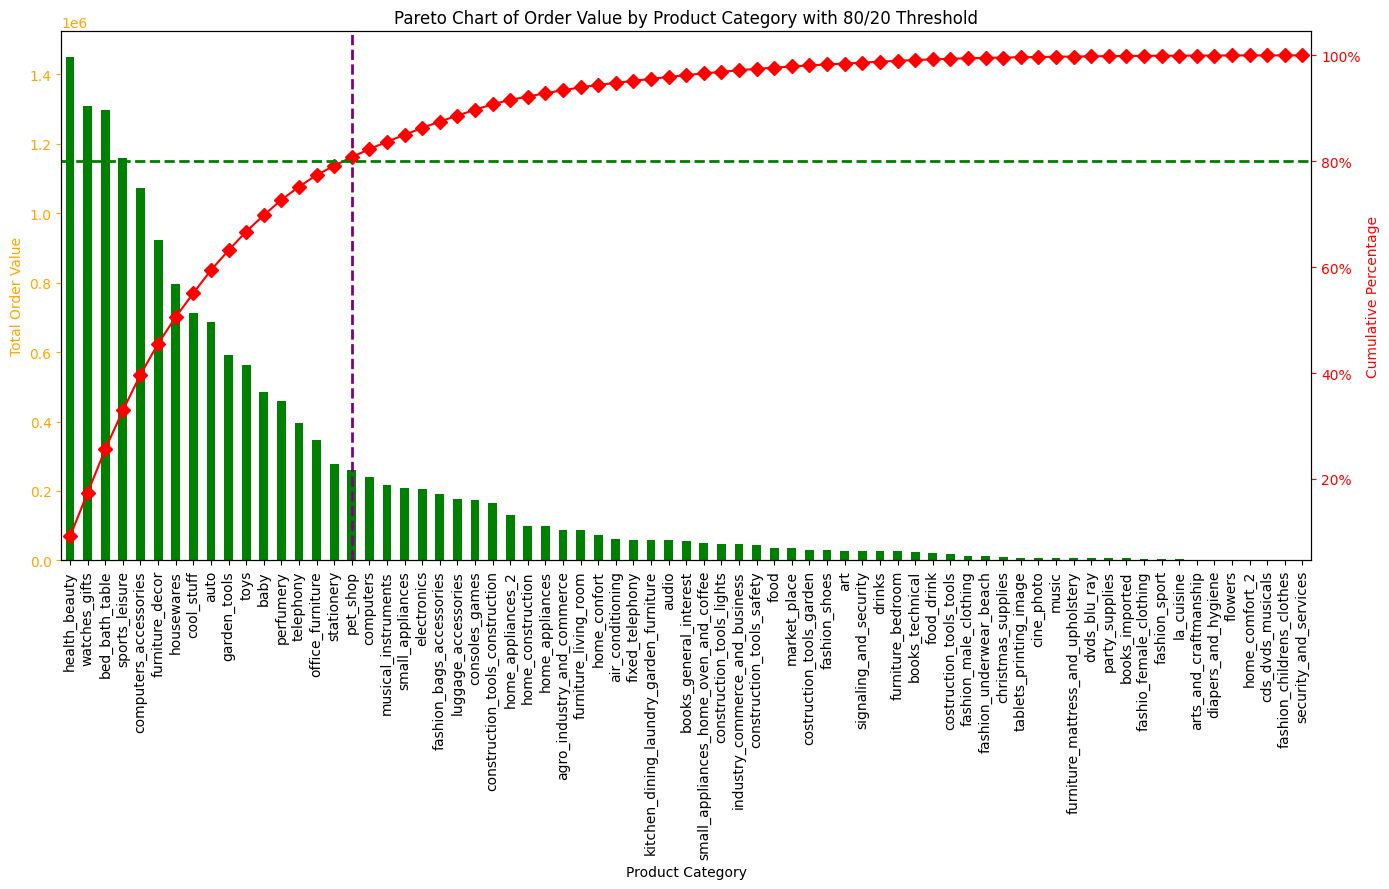

In [43]:
# Calculate the total order value by category
order_value_by_category = merged_df.groupby('product_category_name_english')['order_value'].sum()
total_order_value = order_value_by_category.sum()
order_value_by_category_percent = (order_value_by_category / total_order_value).cumsum() * 100

# Correcting the approach for the Pareto Chart of Order Value by Product Category

# Sorting the order values by category in descending order
sorted_order_value_by_category = order_value_by_category.sort_values(ascending=False)
cumulative_order_value_percent = sorted_order_value_by_category.cumsum() / total_order_value * 100

# Recreating the Pareto Chart with the correct approach
fig, ax = plt.subplots(figsize=(14, 9))
sorted_order_value_by_category.plot(kind='bar', ax=ax, color='green')
ax2 = ax.twinx()
ax2.plot(cumulative_order_value_percent.index, cumulative_order_value_percent.values, color='red', marker='D', ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Adding lines for the 80% threshold
ax2.axhline(80, color='green', linestyle='--', linewidth=2)
category_80_idx_corrected = cumulative_order_value_percent[cumulative_order_value_percent >= 80].index[0]
category_80_position_corrected = cumulative_order_value_percent.index.get_loc(category_80_idx_corrected)

ax.axvline(category_80_position_corrected, color='purple', linestyle='--', linewidth=2)

ax.tick_params(axis='y', colors='orange')
ax2.tick_params(axis='y', colors='red')
ax.set_xlabel('Product Category')
ax.set_ylabel('Total Order Value', color='orange')
ax2.set_ylabel('Cumulative Percentage', color='red')
plt.title('Pareto Chart of Order Value by Product Category with 80/20 Threshold')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



##### ***Pareto Chart of Order Value by Product Category with 80/20 Threshold:*** A small number of categories generate most of the revenue, showing market focus areas or best-sellers.

- ### *We can use above insight in targeted Marketing efforts by :*

1. Allocate more budget to advertise the top-performing product categories that contribute most to your sales volume to maximize ROI.
2. Create bundles or promotions that include high-value items with other products to increase the overall order value.

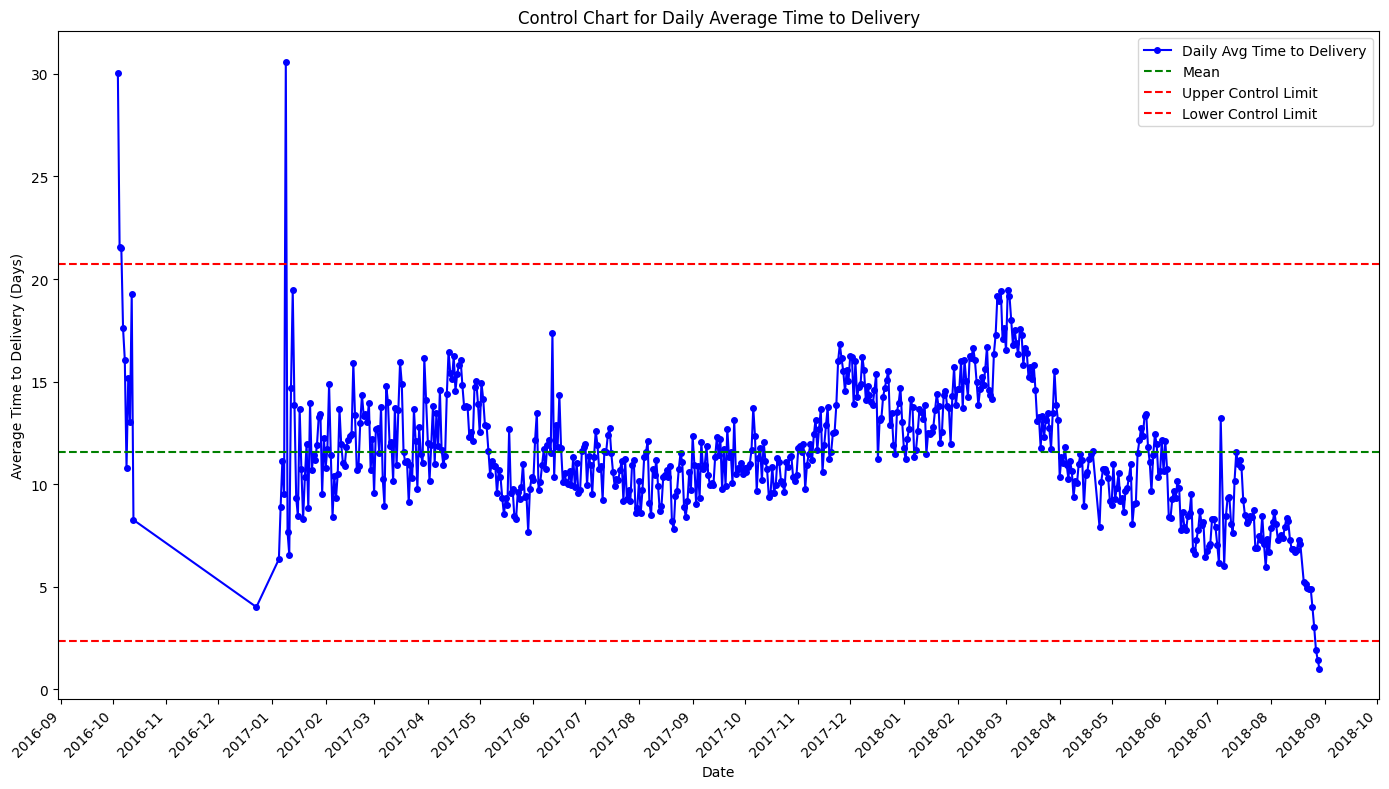

In [44]:
from matplotlib import dates as mdates

# Preparing data for Control Chart: Calculate daily average time to delivery
daily_delivery_times = merged_df.copy()
daily_delivery_times['order_approved_at'] = pd.to_datetime(daily_delivery_times['order_approved_at'])
daily_delivery_times.set_index('order_approved_at', inplace=True)
daily_avg_delivery_time = daily_delivery_times['time_to_delivery'].resample('D').mean().dropna()

# Control Chart calculations
mean_delivery_time = daily_avg_delivery_time.mean()
std_dev_delivery_time = daily_avg_delivery_time.std()
upper_control_limit = mean_delivery_time + (std_dev_delivery_time * 3)
lower_control_limit = mean_delivery_time - (std_dev_delivery_time * 3)

# Plotting the Control Chart
fig, ax = plt.subplots(figsize=(14, 8))
daily_avg_delivery_time.plot(ax=ax, marker='o', linestyle='-', color='blue', markersize=4)
ax.axhline(mean_delivery_time, color='green', linestyle='--')
ax.axhline(upper_control_limit, color='red', linestyle='--')
ax.axhline(lower_control_limit, color='red', linestyle='--')

# Formatting the plot
ax.set_title('Control Chart for Daily Average Time to Delivery')
ax.set_xlabel('Date')
ax.set_ylabel('Average Time to Delivery (Days)')
ax.legend(['Daily Avg Time to Delivery', 'Mean', 'Upper Control Limit', 'Lower Control Limit'])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### ***Control Chart for Daily Average Time to Delivery:*** Delivery times are generally consistent, but spikes suggest occasional delays that could impact customer satisfaction.

C:\Users\ADV\AppData\Local\Temp\ipykernel_15572\491425676.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




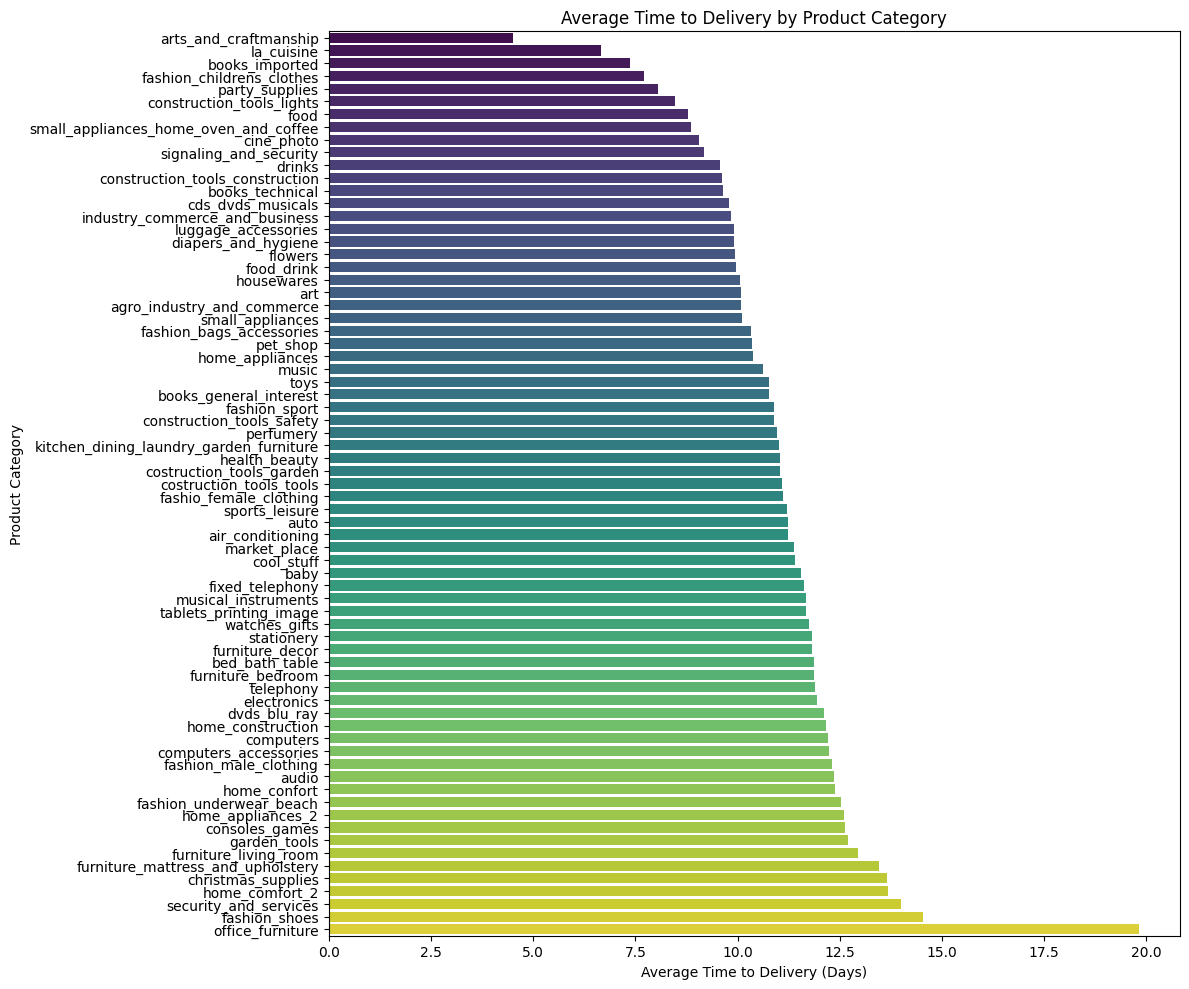

In [45]:
# Analyzing the Variability of Time to Delivery Across Different Product Categories
category_delivery_times = merged_df.groupby('product_category_name_english')['time_to_delivery'].mean().sort_values()

plt.figure(figsize=(12, 10))
sns.barplot(x=category_delivery_times.values, y=category_delivery_times.index, palette="viridis")
plt.title('Average Time to Delivery by Product Category')
plt.xlabel('Average Time to Delivery (Days)')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()


##### Top Product Categories for Late Deliveries:

1. Bed Bath & Table
2. Health Beauty
3. Sports Leisure
4. Furniture Decor
5. Computers Accessories
##### These categories have the highest numbers of late deliveries, suggesting specific challenges related to these product types or their supply chains.

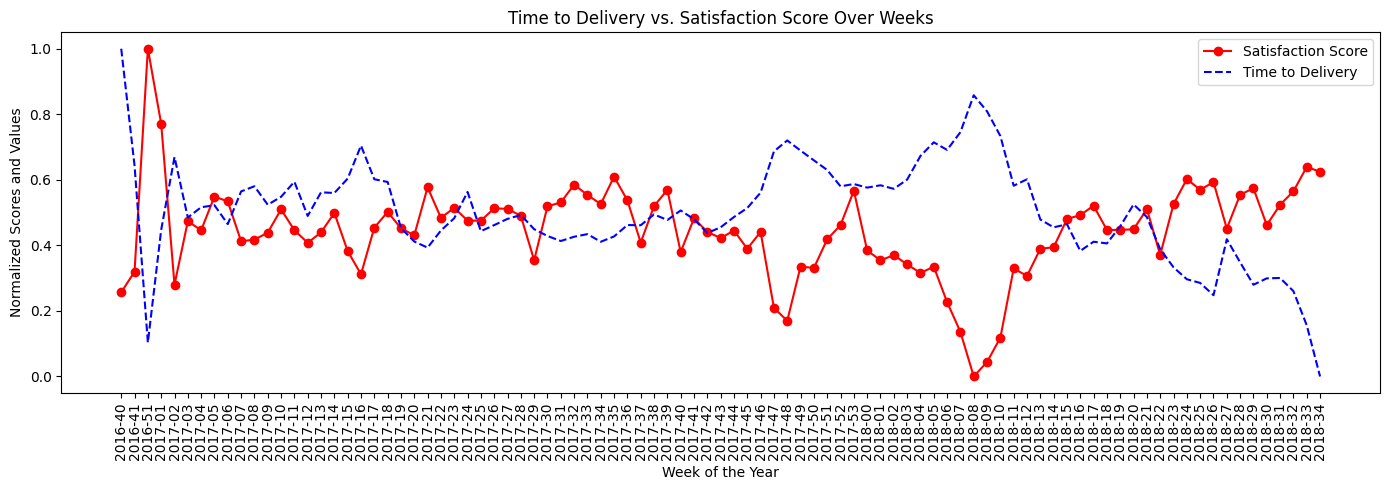

In [46]:
# Calculate the average satisfaction score over weeks
merged_df['order_approved_at'] = pd.to_datetime(merged_df['order_approved_at'])
merged_df['week_year'] = merged_df['order_approved_at'].dt.strftime('%Y-%U')

# Calculating average satisfaction score over weeks
weekly_satisfaction = merged_df.groupby('week_year')['satisfaction'].mean().reset_index()

# Adding more features for analysis: Average time to delivery and order value per week
weekly_features = merged_df.groupby('week_year').agg({
    'time_to_delivery': 'mean',
    'order_value': 'mean',
    'satisfaction': 'mean'
}).reset_index()

# Additional feature: Number of Late Deliveries per week
weekly_late_deliveries = merged_df.groupby('week_year')['late_delivery'].sum()

# Normalize the additional features to compare them on the same scale as satisfaction scores
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

weekly_features_scaled = weekly_features.copy()
weekly_features_scaled[['time_to_delivery', 'order_value', 'satisfaction']] = scaler.fit_transform(
    weekly_features[['time_to_delivery', 'order_value', 'satisfaction']]
)

# Adding normalized number of late deliveries
weekly_features_scaled['late_deliveries_normalized'] = scaler.fit_transform(weekly_late_deliveries.values.reshape(-1, 1))

# Time to Delivery and Satisfaction Score
plt.figure(figsize=(14, 5))
plt.plot(weekly_features_scaled['week_year'], weekly_features_scaled['satisfaction'], label='Satisfaction Score', color='red', marker='o')
plt.plot(weekly_features_scaled['week_year'], weekly_features_scaled['time_to_delivery'], label='Time to Delivery', color='blue', linestyle='--')
plt.title('Time to Delivery vs. Satisfaction Score Over Weeks')
plt.xlabel('Week of the Year')
plt.ylabel('Normalized Scores and Values')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### **Time to Delivery vs. Satisfaction Score:** This graph emphasizes the relationship between delivery times and customer satisfaction, allowing us to identify patterns where longer or shorter delivery times might impact satisfaction levels.

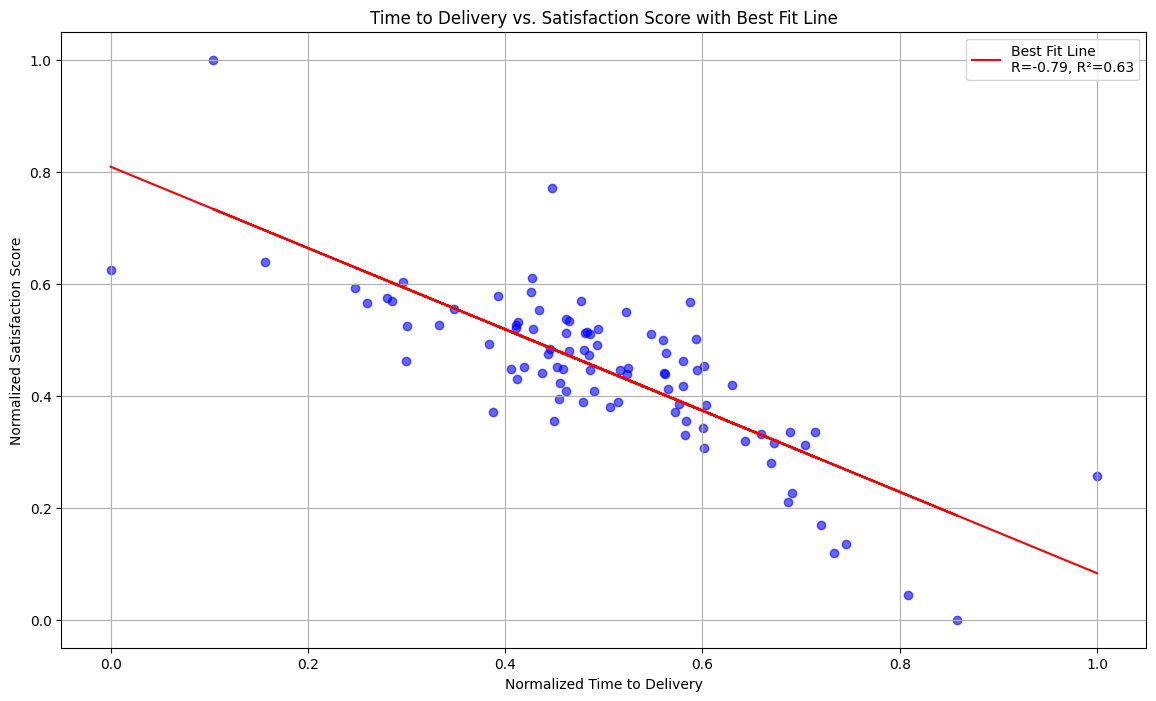

In [47]:
from scipy.stats import linregress

# Calculating the linear regression between Time to Delivery and Satisfaction Score
slope, intercept, r_value, p_value, std_err = linregress(weekly_features_scaled['time_to_delivery'], weekly_features_scaled['satisfaction'])

# Calculate the best fit line
line = slope * weekly_features_scaled['time_to_delivery'] + intercept

# Scatter Plot with Best Fit Line
plt.figure(figsize=(14, 8))
plt.scatter(weekly_features_scaled['time_to_delivery'], weekly_features_scaled['satisfaction'], color='blue', alpha=0.6)
plt.plot(weekly_features_scaled['time_to_delivery'], line, color='red', label=f'Best Fit Line\nR={r_value:.2f}, R²={r_value**2:.2f}')

plt.title('Time to Delivery vs. Satisfaction Score with Best Fit Line')
plt.xlabel('Normalized Time to Delivery')
plt.ylabel('Normalized Satisfaction Score')
plt.legend()
plt.grid(True)
plt.show()

### **Interpretation:**
##### **Correlation Score (R):** The correlation score of -0.79 indicates a strong negative relationship between Time to Delivery and Satisfaction Score. This suggests that as the time to delivery increases, the satisfaction score tends to decrease, and vice versa.
##### **R² Value:** The R² value of 0.62 means that approximately 62% of the variability in the satisfaction scores can be explained by the variability in the time to delivery. This is a substantial proportion, highlighting the significant impact of delivery time on customer satisfaction on a weekly level.
These scores underscore the importance of efficient delivery processes as a key driver of customer satisfaction. Efforts to reduce delivery times could therefore be expected to have a positive effect on overall satisfaction scores.

# Machine Learning models

# Predict Customer Satisfaction

In [48]:
# Identifying top 10 features with highest correlation with 'satisfaction'
# Select only the numeric columns for correlation calculation
numeric_cols = merged_df.select_dtypes(include=[np.number])

# Compute the correlation matrix for numeric columns only
corr_matrix = numeric_cols.corr()

# Print the top 10 features correaltion score
print(corr_matrix['satisfaction'].sort_values(ascending=False)[1:-1])


estimated_vs_actual_shipping    0.200293
order_month                     0.027864
order_hour                      0.009535
price                           0.008271
payment_sequential              0.007372
order_value                     0.005543
product_width_cm               -0.012533
order_day                      -0.015242
product_length_cm              -0.017906
order_processing_time          -0.018413
product_height_cm              -0.020917
customer_zip_code_prefix       -0.022217
product_volume_m3              -0.022307
product_weight_g               -0.023465
freight_value                  -0.028962
payment_installments           -0.042748
payment_value                  -0.068124
order_item_id                  -0.121016
time_to_delivery               -0.267583
Name: satisfaction, dtype: float64


### The top features that have the highest correlation with 'satisfaction'

In [49]:
# Set the correlation threshold
threshold = 0.05

# Get the features with correlation greater than 7% or less than -7% with 'satisfaction'
high_corr_features = corr_matrix.index[(corr_matrix['satisfaction'].abs() > threshold) & (corr_matrix.index != 'satisfaction')].tolist()

# Print the highly correlated features
print(high_corr_features)


['order_item_id', 'payment_value', 'time_to_delivery', 'estimated_vs_actual_shipping', 'late_delivery']


In [50]:
# check data types for top 10 features
merged_df[high_corr_features].dtypes

order_item_id                   float64
payment_value                   float64
time_to_delivery                  int64
estimated_vs_actual_shipping      int64
late_delivery                     int64
dtype: object

### Above features have negative or positive correlation with 'satisfaction'

In [51]:
# need to take only 5 features
top_4_features = ['payment_value', 'time_to_delivery', 'estimated_vs_actual_shipping', 'late_delivery']

Evaluating Logistic Regression


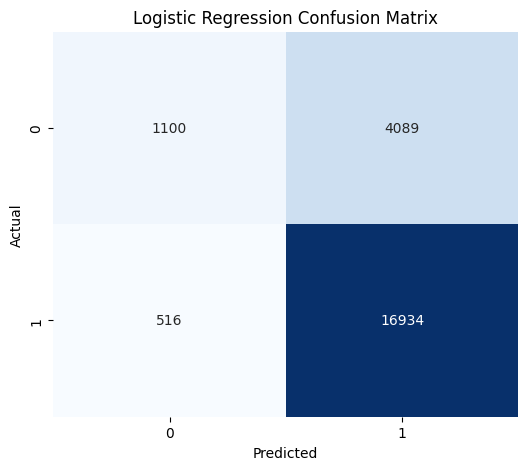

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.21      0.32      5189
           1       0.81      0.97      0.88     17450

    accuracy                           0.80     22639
   macro avg       0.74      0.59      0.60     22639
weighted avg       0.78      0.80      0.75     22639

Evaluating Decision Tree


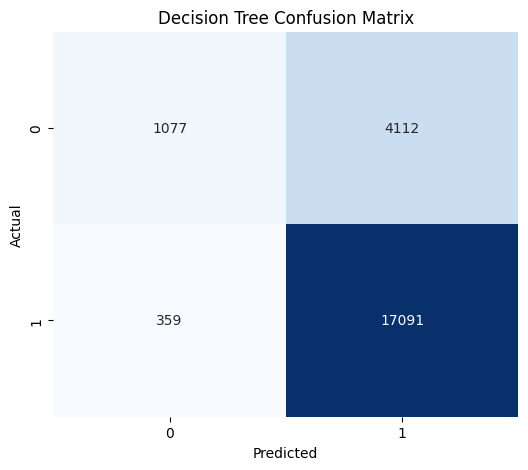

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.21      0.33      5189
           1       0.81      0.98      0.88     17450

    accuracy                           0.80     22639
   macro avg       0.78      0.59      0.60     22639
weighted avg       0.79      0.80      0.76     22639

Evaluating Random Forest


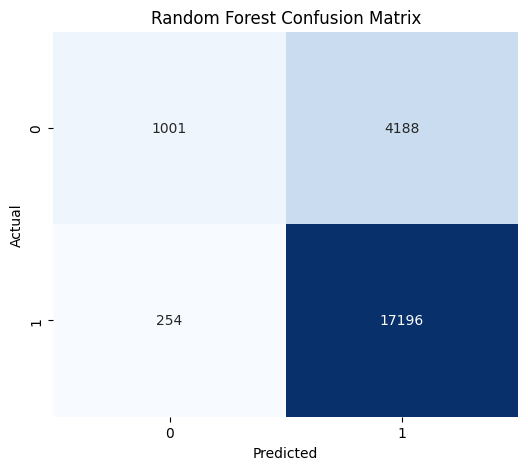

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.19      0.31      5189
           1       0.80      0.99      0.89     17450

    accuracy                           0.80     22639
   macro avg       0.80      0.59      0.60     22639
weighted avg       0.80      0.80      0.75     22639

Evaluating XGBoost


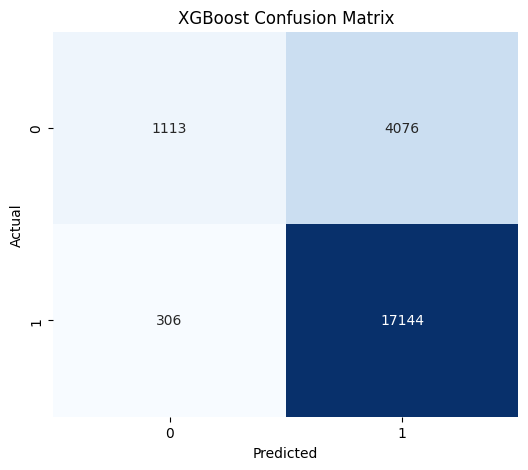

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.21      0.34      5189
           1       0.81      0.98      0.89     17450

    accuracy                           0.81     22639
   macro avg       0.80      0.60      0.61     22639
weighted avg       0.80      0.81      0.76     22639



In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting only the top 6 features
top_6_features = ['estimated_vs_actual_shipping', 'order_month', 'order_hour', 'price', 'payment_sequential', 'order_value', 'payment_installments']
X = merged_df[top_4_features]
y = merged_df['satisfaction']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Applying ColumnTransformer to preprocess the data
preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, top_4_features)]
)

# Preprocessing the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=50),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=4),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

# Function to fit models, make predictions, and evaluate them
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Plotting confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    print(f"{model_name} Classification Report:")
    print(class_report)

# Evaluate each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}")
    evaluate_model(model, X_train_preprocessed, y_train, X_test_preprocessed, y_test, model_name)

In [54]:
from sklearn.model_selection import GridSearchCV

# Initialize the XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Fewer trees to keep the model simpler
    'max_depth': [3, 4, 5],          # Shallow trees to prevent overfitting
    'learning_rate': [0.1, 0.01, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',  # or another scoring metric
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train_preprocessed, y_train)

# Retrieve the best model
best_model = grid_search.best_estimator_

# Predictions
train_preds = best_model.predict(X_train_preprocessed)
test_preds = best_model.predict(X_test_preprocessed)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


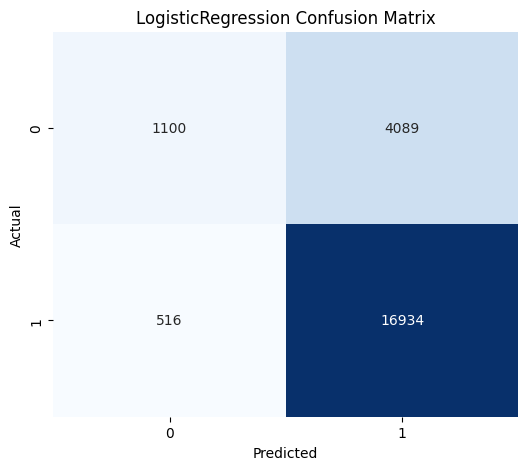

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.21      0.32      5189
           1       0.81      0.97      0.88     17450

    accuracy                           0.80     22639
   macro avg       0.74      0.59      0.60     22639
weighted avg       0.78      0.80      0.75     22639



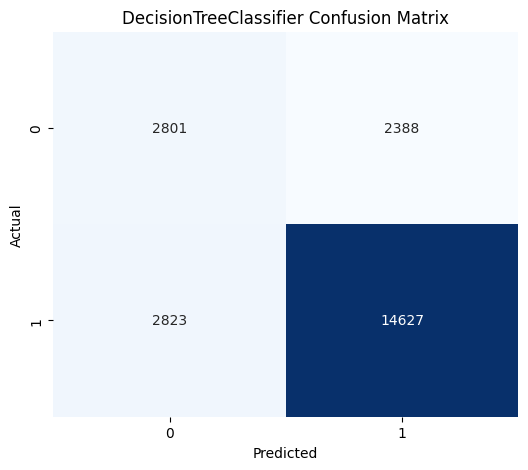

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.54      0.52      5189
           1       0.86      0.84      0.85     17450

    accuracy                           0.77     22639
   macro avg       0.68      0.69      0.68     22639
weighted avg       0.78      0.77      0.77     22639



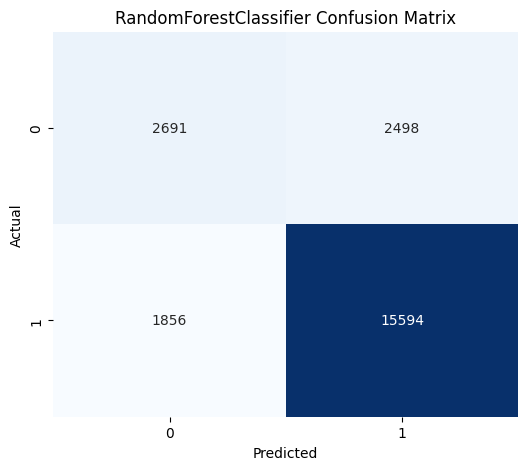

RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.52      0.55      5189
           1       0.86      0.89      0.88     17450

    accuracy                           0.81     22639
   macro avg       0.73      0.71      0.72     22639
weighted avg       0.80      0.81      0.80     22639



RandomForestClassifier(random_state=42)

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initializing models
log_reg = LogisticRegression(random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)

# A function to fit models, make predictions, and evaluate them
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Plotting confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model.__class__.__name__} Confusion Matrix')
    plt.show()
    
    print(f"{model.__class__.__name__} Classification Report:")
    print(class_report)
    return model

# Evaluating Logistic Regression
evaluate_model(log_reg, X_train_preprocessed, y_train, X_test_preprocessed, y_test)

# Evaluating Decision Tree
evaluate_model(decision_tree, X_train_preprocessed, y_train, X_test_preprocessed, y_test)

# Evaluating Random Forest
evaluate_model(random_forest, X_train_preprocessed, y_train, X_test_preprocessed, y_test)

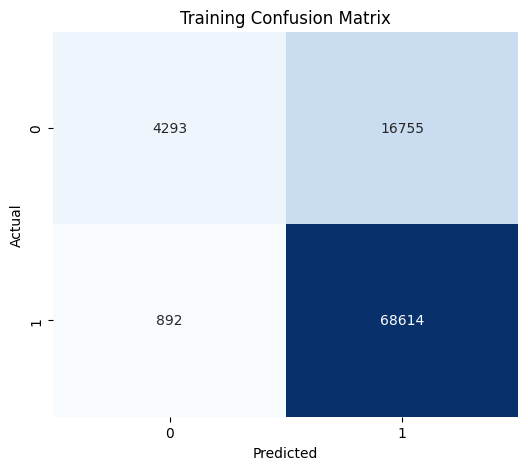

Training Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.20      0.33     21048
           1       0.80      0.99      0.89     69506

    accuracy                           0.81     90554
   macro avg       0.82      0.60      0.61     90554
weighted avg       0.81      0.81      0.76     90554



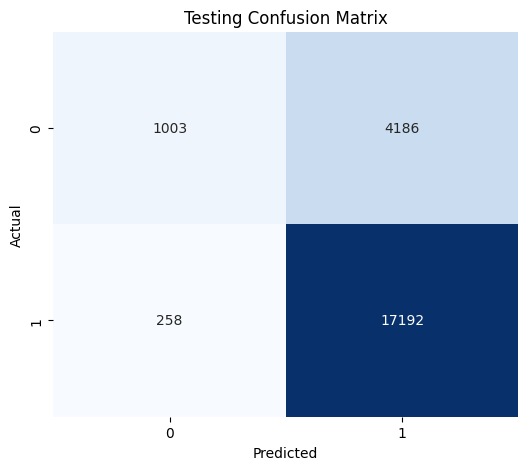

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.19      0.31      5189
           1       0.80      0.99      0.89     17450

    accuracy                           0.80     22639
   macro avg       0.80      0.59      0.60     22639
weighted avg       0.80      0.80      0.75     22639

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}
Best Score: 0.8014775608575576


In [56]:
# Function to plot confusion matrix
def plot_confusion_matrix(true_values, predictions, set_name):
    matrix = confusion_matrix(true_values, predictions)
    plt.figure(figsize=(6,5))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{set_name} Confusion Matrix')
    plt.show()

# Function to print classification report
def print_classification_report(true_values, predictions, set_name):
    report = classification_report(true_values, predictions)
    print(f"{set_name} Classification Report:")
    print(report)

# Visualize and print reports for both sets
plot_confusion_matrix(y_train, train_preds, "Training")
print_classification_report(y_train, train_preds, "Training")

plot_confusion_matrix(y_test, test_preds, "Testing")
print_classification_report(y_test, test_preds, "Testing")

# Print best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [57]:
# Create the final pipeline using the best model
final_pipeline = Pipeline(steps=[('preprocessing', preprocessor),
    ('classifier', xgb_model)
])

final_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['payment_value',
                                                   'time_to_delivery',
                                                   'estimated_vs_actual_shipping',
                                                   'late_delivery'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, devic...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [58]:
# Fit the pipeline to your data
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['payment_value',
                                                   'time_to_delivery',
                                                   'estimated_vs_actual_shipping',
                                                   'late_delivery'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, devic...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [59]:
X_train.columns

Index(['payment_value', 'time_to_delivery', 'estimated_vs_actual_shipping',
       'late_delivery'],
      dtype='object')

In [60]:
X_train.describe()

,payment_value,time_to_delivery,estimated_vs_actual_shipping,late_delivery
count,90554.000000,90554.000000,90554.000000,90554.000000
mean,171.102164,11.520728,11.095081,0.076971
std,263.791159,9.416932,10.177117,0.266546
min,0.000000,-7.000000,-189.000000,0.000000
25%,60.640000,6.000000,6.000000,0.000000
50%,107.780000,9.000000,12.000000,0.000000
75%,188.667500,15.000000,16.000000,0.000000
max,13664.080000,208.000000,146.000000,1.000000


In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90554 entries, 73387 to 16559
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   payment_value                 90554 non-null  float64
 1   time_to_delivery              90554 non-null  int64  
 2   estimated_vs_actual_shipping  90554 non-null  int64  
 3   late_delivery                 90554 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.5 MB


In [62]:
# 3) Save pipeline as pkl file
import joblib

joblib.dump(final_pipeline, 'final_ECommerce_model.pkl')

['final_ECommerce_model.pkl']

In [63]:
model = joblib.load('final_ECommerce_model.pkl')

### Testing

In [64]:
import random

class SatisfactionFinder:
    def __init__(self, model, preprocessor, features, trials=50):
        self.model = model
        self.preprocessor = preprocessor
        self.features = features
        self.trials = trials

    def random_input(self):
        """Generate a random input within plausible ranges for each feature."""
        ranges = {
            'estimated_vs_actual_shipping': (-189, 146),
            'time_to_delivery': (-7, 208),  # Updated with correct range
            'payment_value': (0.0, 13664.08),  # Updated with correct range
            'order_item_id': (1.0, 21.0),  # Updated with correct range
            'late_delivery': (0, 1)  # Binary feature
        }

        # Generate a random value within each range
        return {feature: random.uniform(*ranges[feature]) if isinstance(ranges[feature][0], float)
                else random.randint(*ranges[feature]) for feature in self.features}

    def find_not_satisfied(self):
        """Loop to find a set of values that predict 'Not Satisfied'."""
        for _ in range(self.trials):
            # Generate random input
            user_data = self.random_input()

            # Convert to DataFrame
            input_df = pd.DataFrame([user_data])

            # Preprocess and predict
            input_preprocessed = self.preprocessor.transform(input_df)
            prediction = self.model.predict(input_preprocessed)

            # Check if prediction is 'Not Satisfied'
            if prediction[0] == 0:
                return user_data, "Not Satisfied"

        return None, "Not found"

# Assuming xgb_model, preprocessor, and top_6_features are previously defined
finder = SatisfactionFinder(xgb_model, preprocessor, ['estimated_vs_actual_shipping', 'time_to_delivery', 'payment_value', 'late_delivery'], trials=200)

# Find a 'Not Satisfied' prediction
user_data, result = finder.find_not_satisfied()

print("User Data:", user_data)
print("Result:", result)


User Data: {'estimated_vs_actual_shipping': -35, 'time_to_delivery': 12, 'payment_value': 10396.825012446274, 'late_delivery': 0}
Result: Not Satisfied


In [65]:
model.predict(pd.DataFrame([{
    'estimated_vs_actual_shipping': 130,
    'time_to_delivery': 133, 
    'payment_value': 9591,
    'late_delivery': 1 
}], dtype=float))

array([0])

In [66]:
model.predict(pd.DataFrame([{
    'estimated_vs_actual_shipping': 5,
    'time_to_delivery': 7,
    'payment_value': 300,
    'late_delivery': 0 
}], dtype=float))

array([1])

In [67]:
%%writefile ECB.py

import streamlit as st
import joblib
import numpy as np

# Load your trained pipeline
model = joblib.load('final_ECommerce_model.pkl')

# Define the structure of your app
def main():
    st.title('Customer Satisfaction Prediction App')

   # Define inputs with appropriate ranges and default values based on your data
    estimated_vs_actual_shipping = st.number_input('Estimated vs Actual Shipping Days', min_value=-189, max_value=146, value=11)
    time_to_delivery = st.number_input('Time to Delivery', min_value=-7, max_value=208, value=9)
    payment_value = st.number_input('Payment Value', min_value=0.0, max_value=13664.08, value=107.78)
    late_delivery = st.number_input('Late Delivery', min_value=0, max_value=1, value=0) 

# Prediction button
    if st.button('Predict Satisfaction'):
        # Create an array with the input data
        # Make sure all inputs are included in the array in the correct order
        input_data = np.array([[estimated_vs_actual_shipping, time_to_delivery, payment_value, late_delivery]])

        # Get the prediction
        prediction = model.predict(input_data)

        # Output the prediction
        if prediction[0] == 1:
            st.success('The customer is satisfied.')
        else:
            st.error('The customer is not satisfied')

if __name__ == '__main__':
    main()

Writing ECB.py
